# <span style="color:red">Variable Overview</span>

Attribute Information
1. Gender: gender of the individual.
2. Birth Date: the birth date of the individual
3. Height: the individual’s height (m)
4. Weight: the individual's weight (kg)
5. family_history_with_overweight: whether the individual has one or more family members who are
overweight
6. High Calorie Meal Freq: whether the individual often consumes high-calorie meals
7. Veggies in Meals freq: the number of times vegetables are consumed in meals daily
8. Daily Main Meals: the number of main meals per day
9. Snack Frequency: the frequency of snack times taken by the individual daily
10. Smoking: whether the individual smokes or not (yes/no)
11. Daily Water Consumption: the amount of water consumed daily (L)
12. Weekly Physical Activity: the average number of physical activities per week
13. Alcohol: frequency of alcohol consumption
14. Transportation: most frequently used means of transportation
15. Obesity level: the individual’s obesity severity

# <span style="color:red">Libraries</span>

In [345]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import shap
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# <span style="color:red">Data Preparation</span>

In [300]:
df = pd.read_csv("1B.tsv", sep='\t')
df.head()

,Gender,Birth Date,Height,Weight,family_history_with_overweight,High Calorie Meal Freq,Veggies in Meals freq,Daily Main Meals,Snack Frequency,Smoking,Daily Water Consumption,Weekly Physical Activity,Alcohol,Transportation,Obesity level
0,Female,2003/02/05,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,0.0,no,Public_Transportation,Normal_Weight
1,Female,2003/06/13,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,3.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,2001/06/25,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,2.0,Frequently,Public_Transportation,Normal_Weight
3,Male,1997/08/14,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,2.0,Frequently,Walking,Overweight_Level_I
4,Male,2002/05/14,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [301]:
df.rename(columns = {'family_history_with_overweight': 'Family History With Overweight'}, inplace = True)

In [302]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Birth Date                      2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   object 
 4   Family History With Overweight  2111 non-null   object 
 5   High Calorie Meal Freq          2111 non-null   object 
 6   Veggies in Meals freq           2111 non-null   float64
 7   Daily Main Meals                2111 non-null   float64
 8   Snack Frequency                 2101 non-null   object 
 9   Smoking                         2111 non-null   object 
 10  Daily Water Consumption         2111 non-null   float64
 11  Weekly Physical Activity        2111 non-null   float64
 12  Alcohol                         21

In [303]:
print(df.describe())

            Height  ...  Weekly Physical Activity
count  2111.000000  ...               2111.000000
mean      1.701677  ...                  1.010298
std       0.093305  ...                  0.850592
min       1.450000  ...                  0.000000
25%       1.630000  ...                  0.124505
50%       1.700499  ...                  1.000000
75%       1.768464  ...                  1.666678
max       1.980000  ...                  3.000000

[8 rows x 5 columns]


### Null and Duplicates Values

In [304]:
df.duplicated().sum()

0

In [305]:
df.isnull().sum()

Gender                             0
Birth Date                         0
Height                             0
Weight                             0
Family History With Overweight     0
High Calorie Meal Freq             0
Veggies in Meals freq              0
Daily Main Meals                   0
Snack Frequency                   10
Smoking                            0
Daily Water Consumption            0
Weekly Physical Activity           0
Alcohol                            0
Transportation                     0
Obesity level                      0
dtype: int64

In [306]:
SFmode = df['Snack Frequency'].mode()
print("Mode:", SFmode[0]) 

Mode: Sometimes


In [307]:
df['Snack Frequency'] = df['Snack Frequency'].fillna('Sometimes')

There are only a few na values, therefore we can replace them with mode (because it is a categorical variable)

In [308]:
count_insufficient_weight = df["Obesity level"].value_counts().get("Insufficient_Weight", 0)
print(f"There are {count_insufficient_weight} rows with 'Insufficient_Weight' before filtering.")


There are 272 rows with 'Insufficient_Weight' before filtering.


In [309]:
df = df[df["Obesity level"] != "Insufficient_Weight"]

Remove the value 'Insufficient_Weight' because there are too many rows with that value, it would risk data integrity.

### Preparing Columns & Variables

In [310]:
Smokingmode = df['Smoking'].mode()
print("Mode:", Smokingmode[0]) 

Mode: no


In [311]:
df['Weight'] = df['Weight'].replace('delapan puluh', 80.0)
df['Smoking'] = df['Smoking'].replace('hehe', 'no')


Replace some weird values such as 'delapan puluh' -> 80 and 'hehe' with the mode of Smoking column. And 

In [312]:
df['Weight'] = pd.to_numeric(df['Weight'], errors='coerce')

In this datasets, the 'Weight' are in string object. It suppose to be numeric, therefore we convert it into numerical

In [313]:
# df['Birth Date'] = pd.to_datetime(df['Birth Date'], format='%Y/%m/%d')
# current_date = datetime.now()
# df['Age'] = current_date.year - df['Birth Date'].dt.year

At first, I considered create another column called 'Age' that is taken from the column "Birth Date" to get their age. But there is no information on when the data was taken. If I randomly create it, it will lead to inaccurate result. Therefore, just drop the column.

In [314]:
df = df.drop(columns = ['Birth Date'])

In [315]:
cat_cols = []
num_cols = []

for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

Categorical: ['Gender', 'Family History With Overweight', 'High Calorie Meal Freq', 'Snack Frequency', 'Smoking', 'Alcohol', 'Transportation', 'Obesity level']
Numeric: ['Height', 'Weight', 'Veggies in Meals freq', 'Daily Main Meals', 'Daily Water Consumption', 'Weekly Physical Activity']


In [316]:
pd.set_option('display.max_rows', None)
for i in cat_cols:
    print(df[i].value_counts(),'\n')

Gender
Male      969
Female    870
Name: count, dtype: int64 

Family History With Overweight
yes    1600
no      239
Name: count, dtype: int64 

High Calorie Meal Freq
yes    1645
no      194
Name: count, dtype: int64 

Snack Frequency
Sometimes     1622
Frequently     120
Always          50
no              47
Name: count, dtype: int64 

Smoking
no     1796
yes      43
Name: count, dtype: int64 

Alcohol
Sometimes     1247
no             522
Frequently      69
Always           1
Name: count, dtype: int64 

Transportation
Public_Transportation    1360
Automobile                411
Walking                    50
Motorbike                  11
Bike                        7
Name: count, dtype: int64 

Obesity level
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Name: count, dtype: int64 



In [317]:
df[num_cols].head()

,Height,Weight,Veggies in Meals freq,Daily Main Meals,Daily Water Consumption,Weekly Physical Activity
0,1.62,64.0,2.0,3.0,2.0,0.0
1,1.52,56.0,3.0,3.0,3.0,3.0
2,1.80,77.0,2.0,3.0,2.0,2.0
3,1.80,87.0,3.0,3.0,2.0,2.0
4,1.78,89.8,2.0,1.0,2.0,0.0


In [318]:
df[cat_cols].head()

,Gender,Family History With Overweight,High Calorie Meal Freq,Snack Frequency,Smoking,Alcohol,Transportation,Obesity level
0,Female,yes,no,Sometimes,no,no,Public_Transportation,Normal_Weight
1,Female,yes,no,Sometimes,yes,Sometimes,Public_Transportation,Normal_Weight
2,Male,yes,no,Sometimes,no,Frequently,Public_Transportation,Normal_Weight
3,Male,no,no,Sometimes,no,Frequently,Walking,Overweight_Level_I
4,Male,no,no,Sometimes,no,Sometimes,Public_Transportation,Overweight_Level_II


# <span style="color:red">EDA</span>

In [319]:
df['Obesity level'].value_counts()

Obesity level
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Name: count, dtype: int64

The Obesity_Type_I category is the most frequent, indicating that this type of obesity is the most commonly occurring in the dataset.

All obesity-related categories (Obesity_Type_I, II, III) combined represent a significant portion of the dataset, suggesting the dataset may focus on populations prone to obesity or related health conditions.

The Overweight_Level_I and Overweight_Level_II categories are identical in count (290 each). This symmetry could indicate a systematic classification approach, potentially derived from thresholds in BMI or another health metric.

Normal_Weight has the lowest count (287), implying that the dataset might underrepresent individuals with a normal weight compared to other groups.

This dataset's class distribution appears relatively balanced, which is beneficial for machine learning models.

### Unique Categorical Vales

In [320]:
for col in cat_cols:
  print(df[col].value_counts(), '\n')

Gender
Male      969
Female    870
Name: count, dtype: int64 

Family History With Overweight
yes    1600
no      239
Name: count, dtype: int64 

High Calorie Meal Freq
yes    1645
no      194
Name: count, dtype: int64 

Snack Frequency
Sometimes     1622
Frequently     120
Always          50
no              47
Name: count, dtype: int64 

Smoking
no     1796
yes      43
Name: count, dtype: int64 

Alcohol
Sometimes     1247
no             522
Frequently      69
Always           1
Name: count, dtype: int64 

Transportation
Public_Transportation    1360
Automobile                411
Walking                    50
Motorbike                  11
Bike                        7
Name: count, dtype: int64 

Obesity level
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Name: count, dtype: int64 



For 'Gender', 'Family History With Overweight', 'High Calorie Meal Freq' and 'Smoking'  can be set as binary which uses Label Encoder.

'Snack Frequency' and 'Transportation'need One-Hot Encoding because it has multiple class.

For 'Obesity Level' , I use Ordinal Encoding because the categories have a natural order

In [321]:
df[num_cols].describe()

,Height,Weight,Veggies in Meals freq,Daily Main Meals,Daily Water Consumption,Weekly Physical Activity
count,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000,1839.000000
mean,1.703239,92.011227,2.409911,2.651791,2.028235,0.974825
std,0.092250,23.529042,0.525542,0.752510,0.612087,0.844163
min,1.450000,42.300000,1.000000,1.000000,1.000000,0.000000
25%,1.630000,75.000000,2.000000,2.635933,1.627732,0.096315
50%,1.700038,87.656029,2.294067,3.000000,2.000000,1.000000
75%,1.770000,110.920908,3.000000,3.000000,2.509341,1.554275
max,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000


### Distribution & Outliers

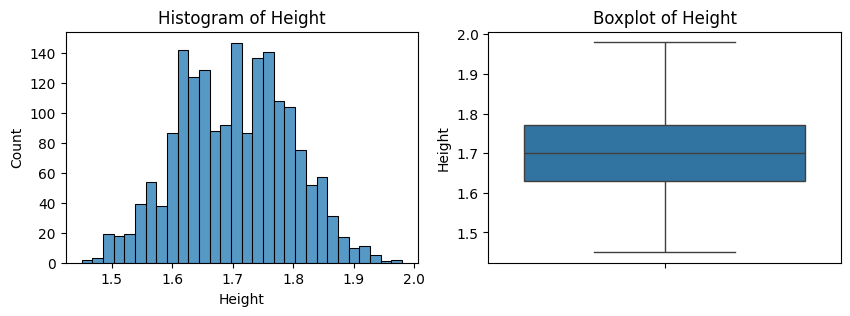

Height - Skewness: 0.011986634964569915
Height - Kurtosis: -0.5150590917529265


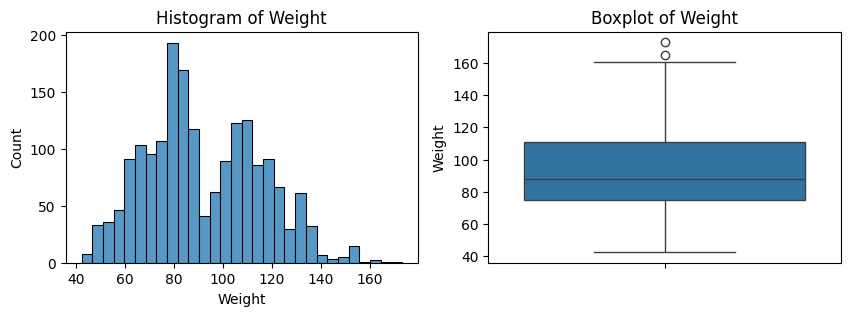

Weight - Skewness: 0.3055634803889106
Weight - Kurtosis: -0.5630716592154252


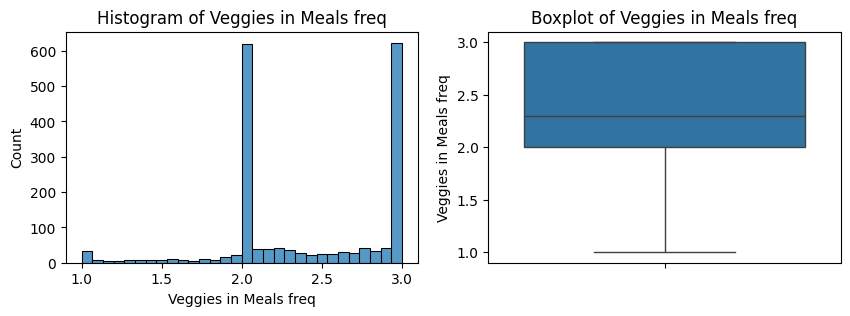

Veggies in Meals freq - Skewness: -0.3292965727956326
Veggies in Meals freq - Kurtosis: -0.7352440007596681


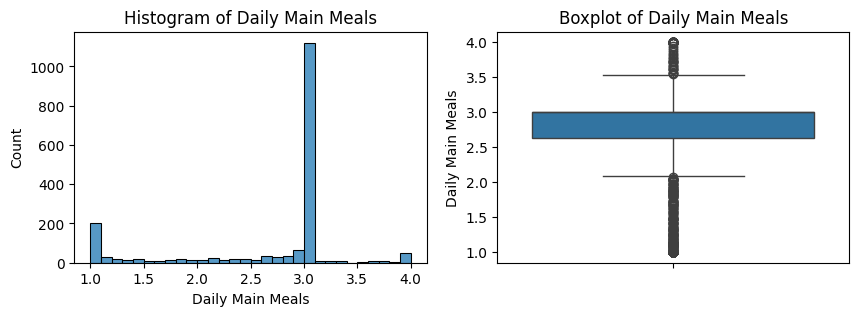

Daily Main Meals - Skewness: -1.2164151050364778
Daily Main Meals - Kurtosis: 0.47707149780837144


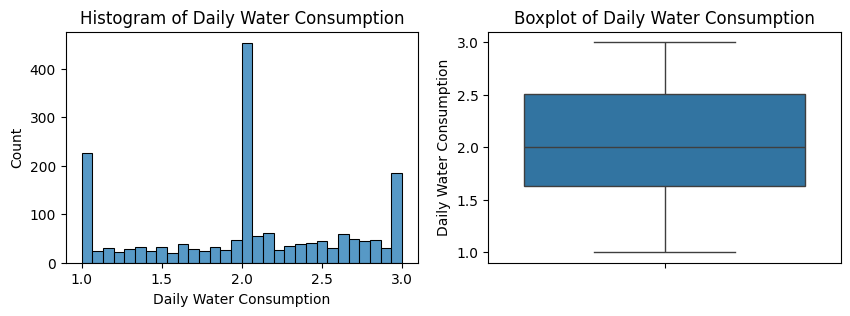

Daily Water Consumption - Skewness: -0.1396726979073435
Daily Water Consumption - Kurtosis: -0.8581835240738491


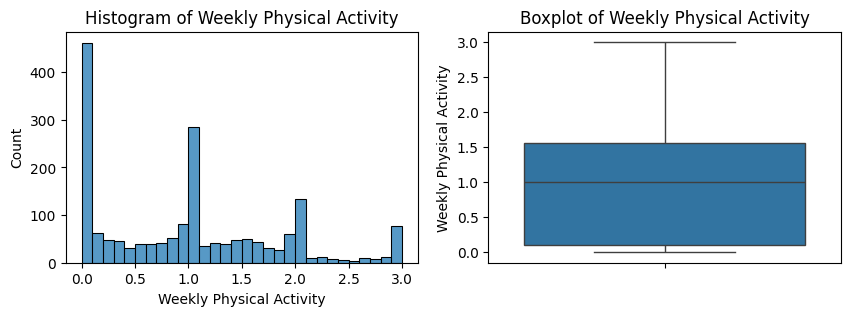

Weekly Physical Activity - Skewness: 0.5996277412136449
Weekly Physical Activity - Kurtosis: -0.41200830111248443


In [322]:
def check_distribution_outliers(dataframe, numerical):
    for col in numerical:
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 2, 1)
        sns.histplot(dataframe[col], bins=30)
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=dataframe[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        print(f'{col} - Skewness: {dataframe[col].skew()}')
        print(f'{col} - Kurtosis: {dataframe[col].kurt()}')

check_distribution_outliers(df[num_cols], num_cols)

Most of the variable has no outliers. But there is one variable that has a lot of outliers, which is 'Daily Main Meals'. This make sense where most of people eats 3 times a day, but there are some people who eat just 1 times a day or 4 times a day. 

Winsorise these outliers may lead to loss of details, this is due to models that we use are tree-based models.

### Numerical Analysis for Obesity Level per Variable

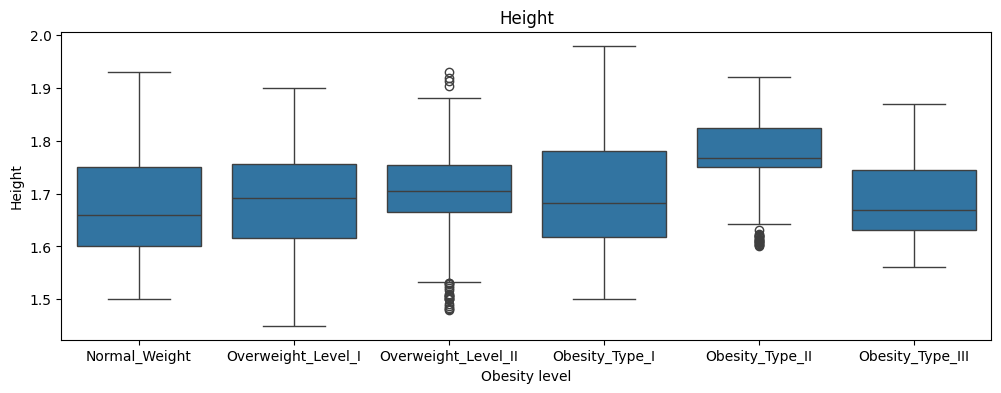

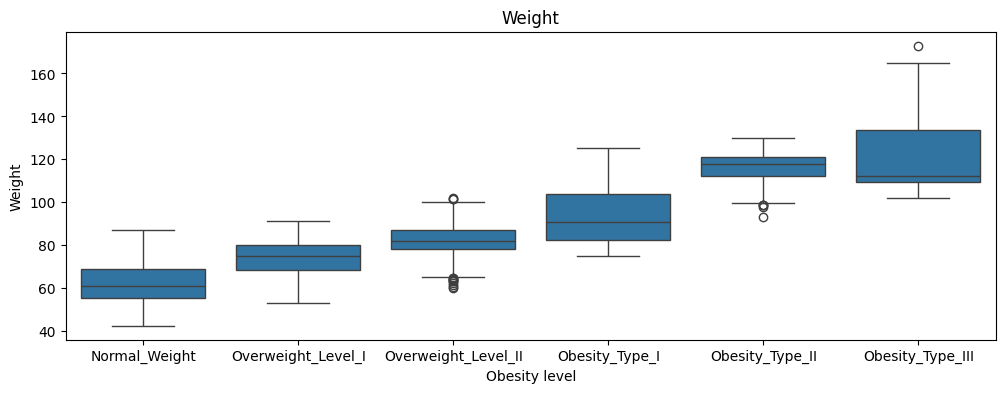

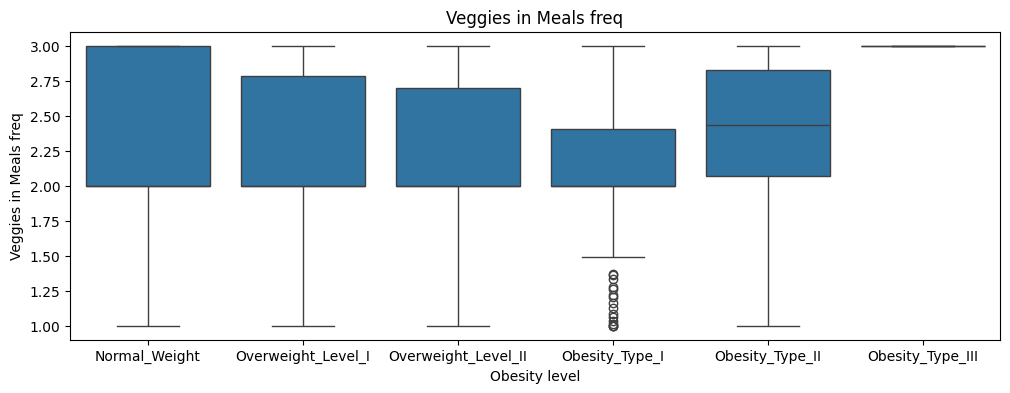

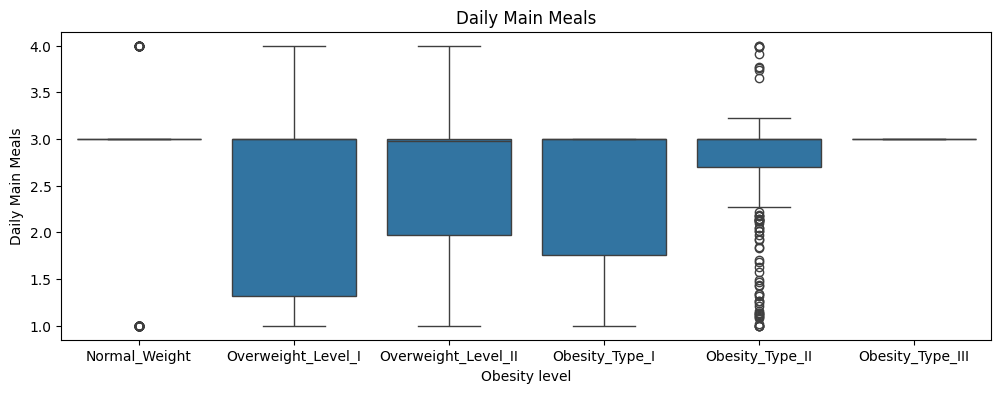

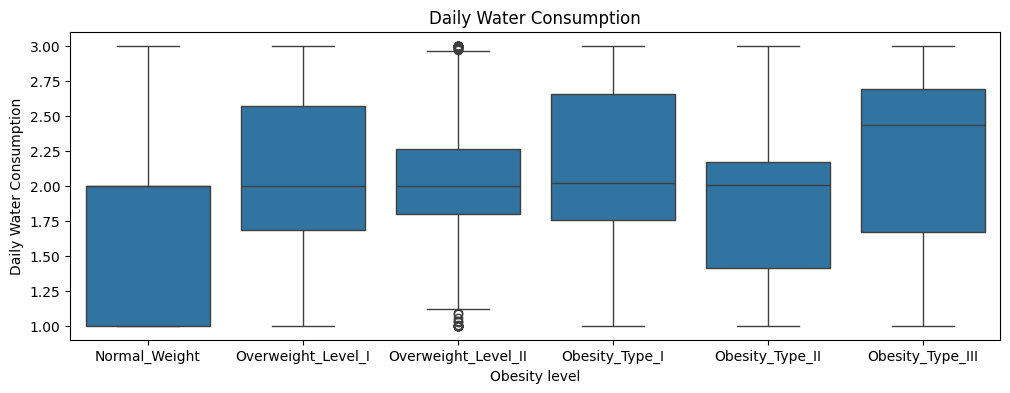

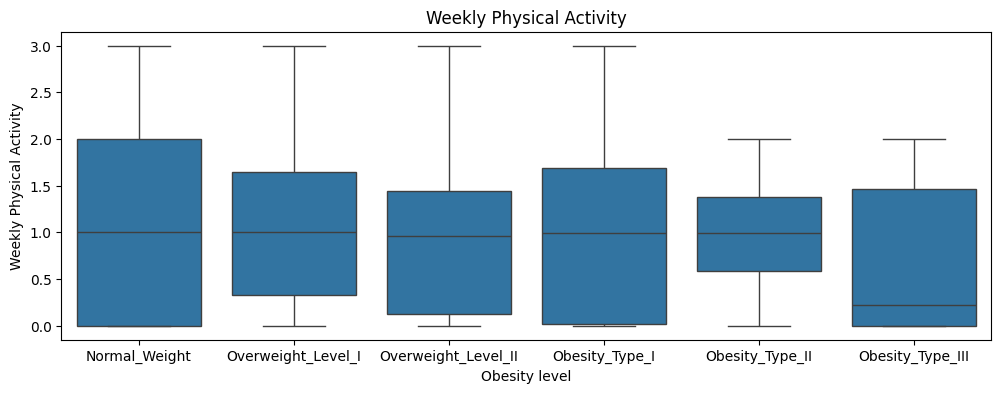

In [323]:
def numerical_distribution(columns):
    for col in columns:
        plt.figure(figsize=(12, 4))

        sns.boxplot(x = df['Obesity level'], y = df[col])
        plt.title(col)

        plt.show()

#Compare each stage
numerical_distribution(num_cols)

Height might have a weak or negligible correlation with obesity level. Taller individuals may have a higher weight baseline, but height alone isn't a direct predictor of obesity.

Weight shows a strong positive correlation with obesity level, as weight is a defining factor of obesity. Higher obesity levels should show significantly higher weights. Outliers might indicate anomalies in weight reporting or individuals with unique health conditions. 

Increased vegetable intake might negatively correlate with obesity level where higher veggie frequency associated with lower obesity. People with higher obesity levels might report fewer vegetables in their meals, revealing dietary habits that contribute to weight gain.

Higher water consumption may positively correlate with obesity levels, Individuals with higher obesity levels (e.g., Obesity Type III) show higher water consumption on average, possibly as part of hydration-focused dietary habits.
Conversely, lower hydration habits may be observed in the Normal Weight and Overweight Level II groups, potentially influencing their metabolic efficiency.


Weekly Physical Activities shows a negative correlation as expected. Higher physical activity levels should correspond to lower obesity levels. Individuals with higher obesity levels might show less physical activity, highlighting the importance of exercise in weight management.

### Categorical Analysis

In [324]:
df.head()

,Gender,Height,Weight,Family History With Overweight,High Calorie Meal Freq,Veggies in Meals freq,Daily Main Meals,Snack Frequency,Smoking,Daily Water Consumption,Weekly Physical Activity,Alcohol,Transportation,Obesity level
0,Female,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,0.0,no,Public_Transportation,Normal_Weight
1,Female,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,3.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,2.0,Frequently,Public_Transportation,Normal_Weight
3,Male,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,2.0,Frequently,Walking,Overweight_Level_I
4,Male,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [325]:
obesity = df.groupby('Obesity level')

ob_df = {ob: data.drop('Obesity level', axis=1) for ob, data in obesity}

ob1 = ob_df['Obesity_Type_I']
ob2 = ob_df['Obesity_Type_II']
ob3 = ob_df['Obesity_Type_III']
ow1 = ob_df['Overweight_Level_I']
ow2 = ob_df['Overweight_Level_II']
nw = ob_df['Normal_Weight']  

cat_cols.remove('Obesity level')

C:\Users\win10\AppData\Local\Temp\ipykernel_13848\4244002769.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=col, loc='upper right')


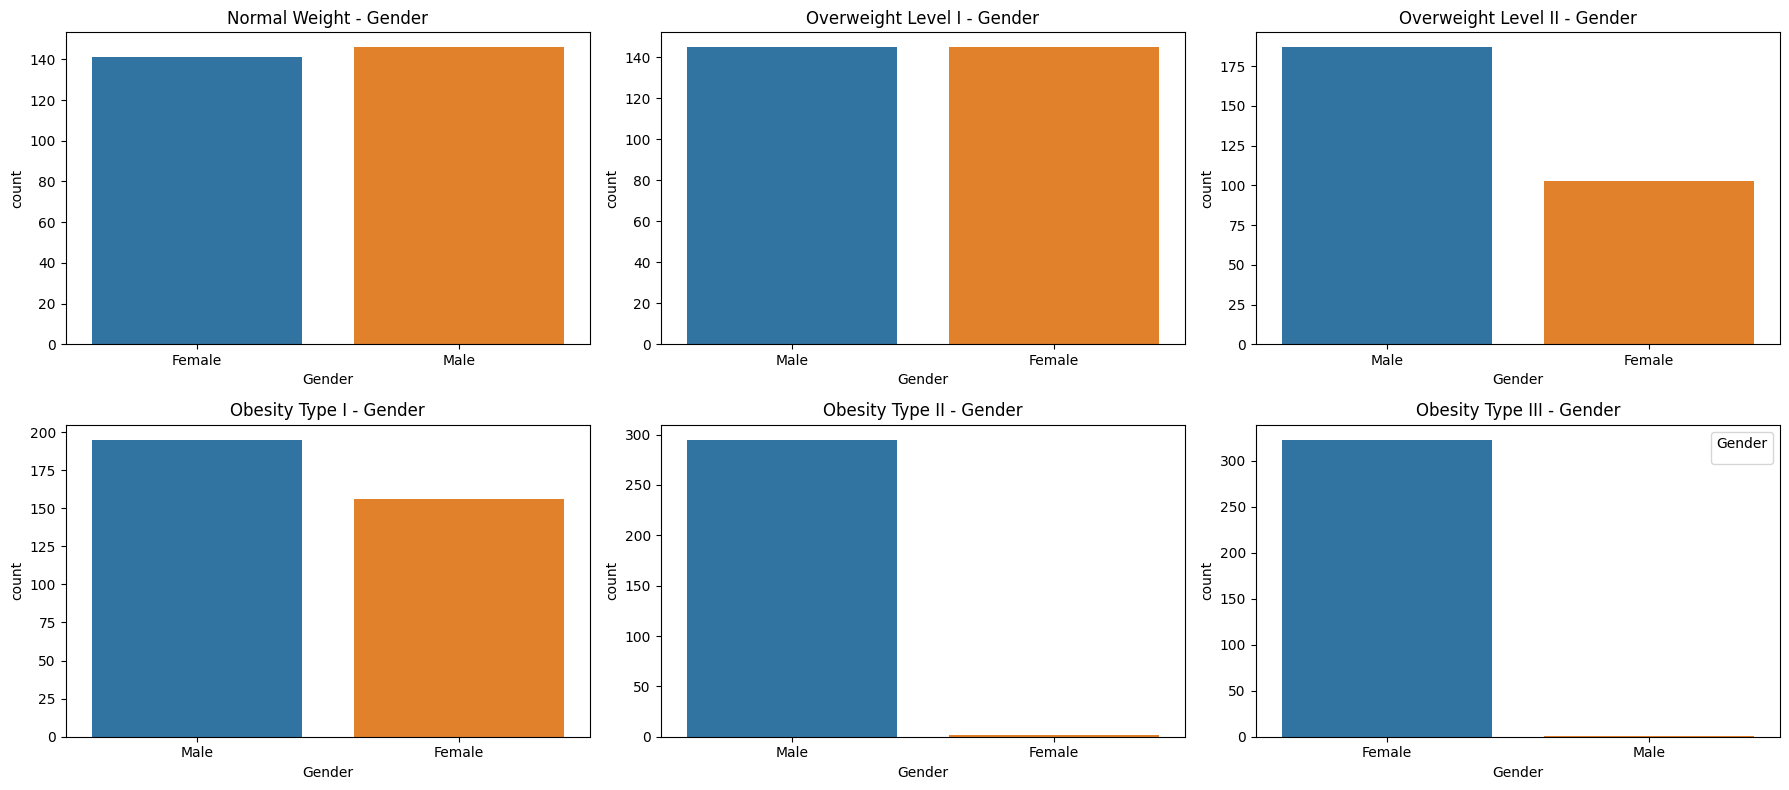

C:\Users\win10\AppData\Local\Temp\ipykernel_13848\4244002769.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=col, loc='upper right')


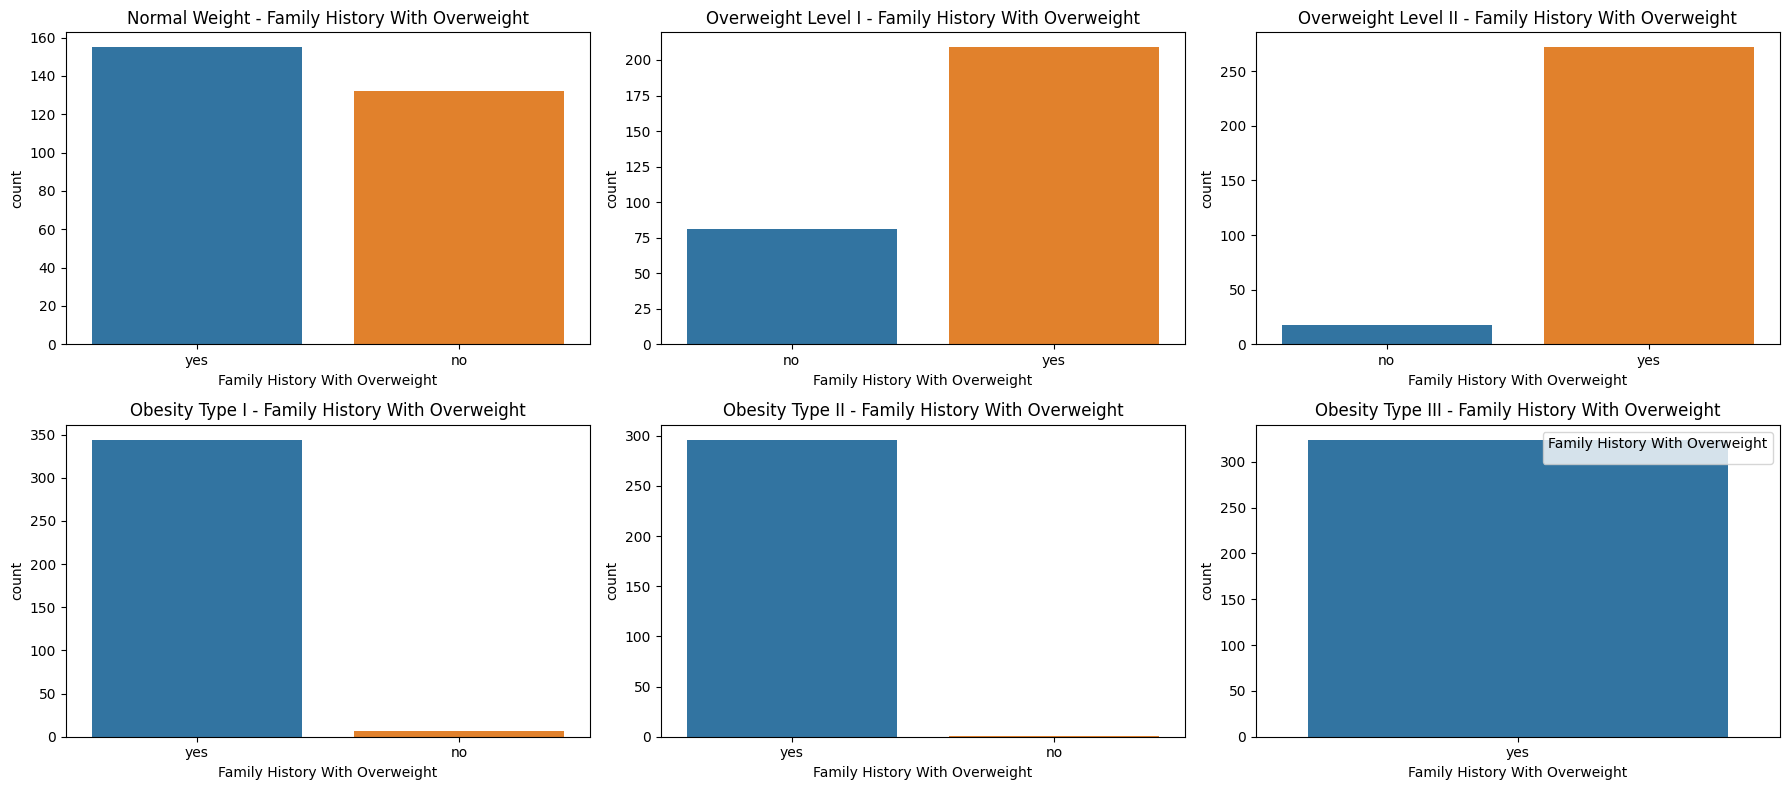

C:\Users\win10\AppData\Local\Temp\ipykernel_13848\4244002769.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=col, loc='upper right')


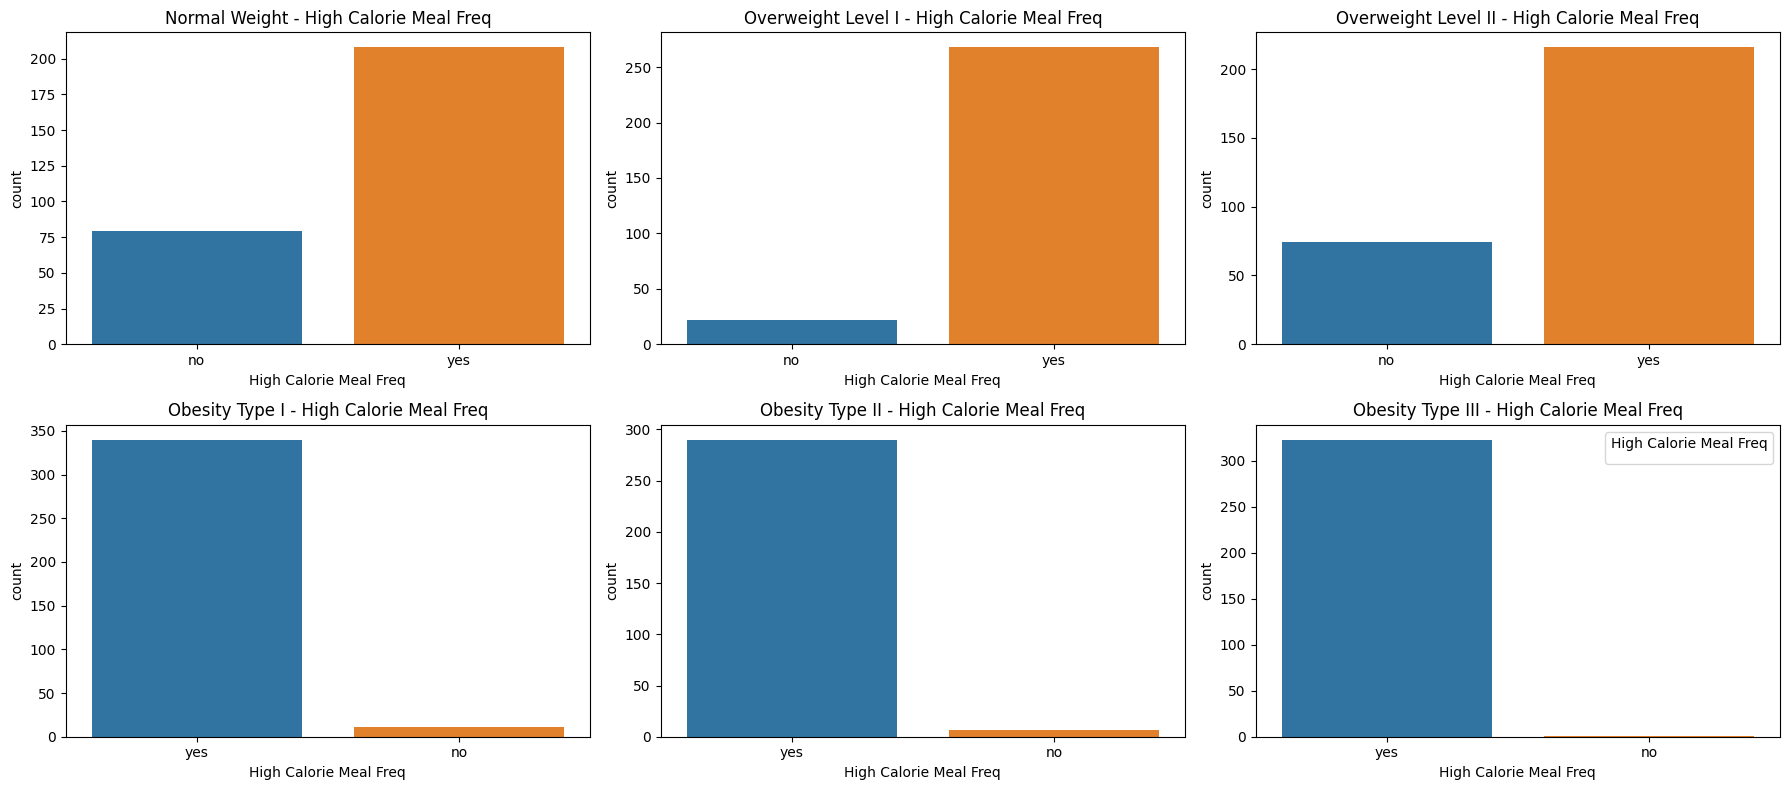

C:\Users\win10\AppData\Local\Temp\ipykernel_13848\4244002769.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=col, loc='upper right')


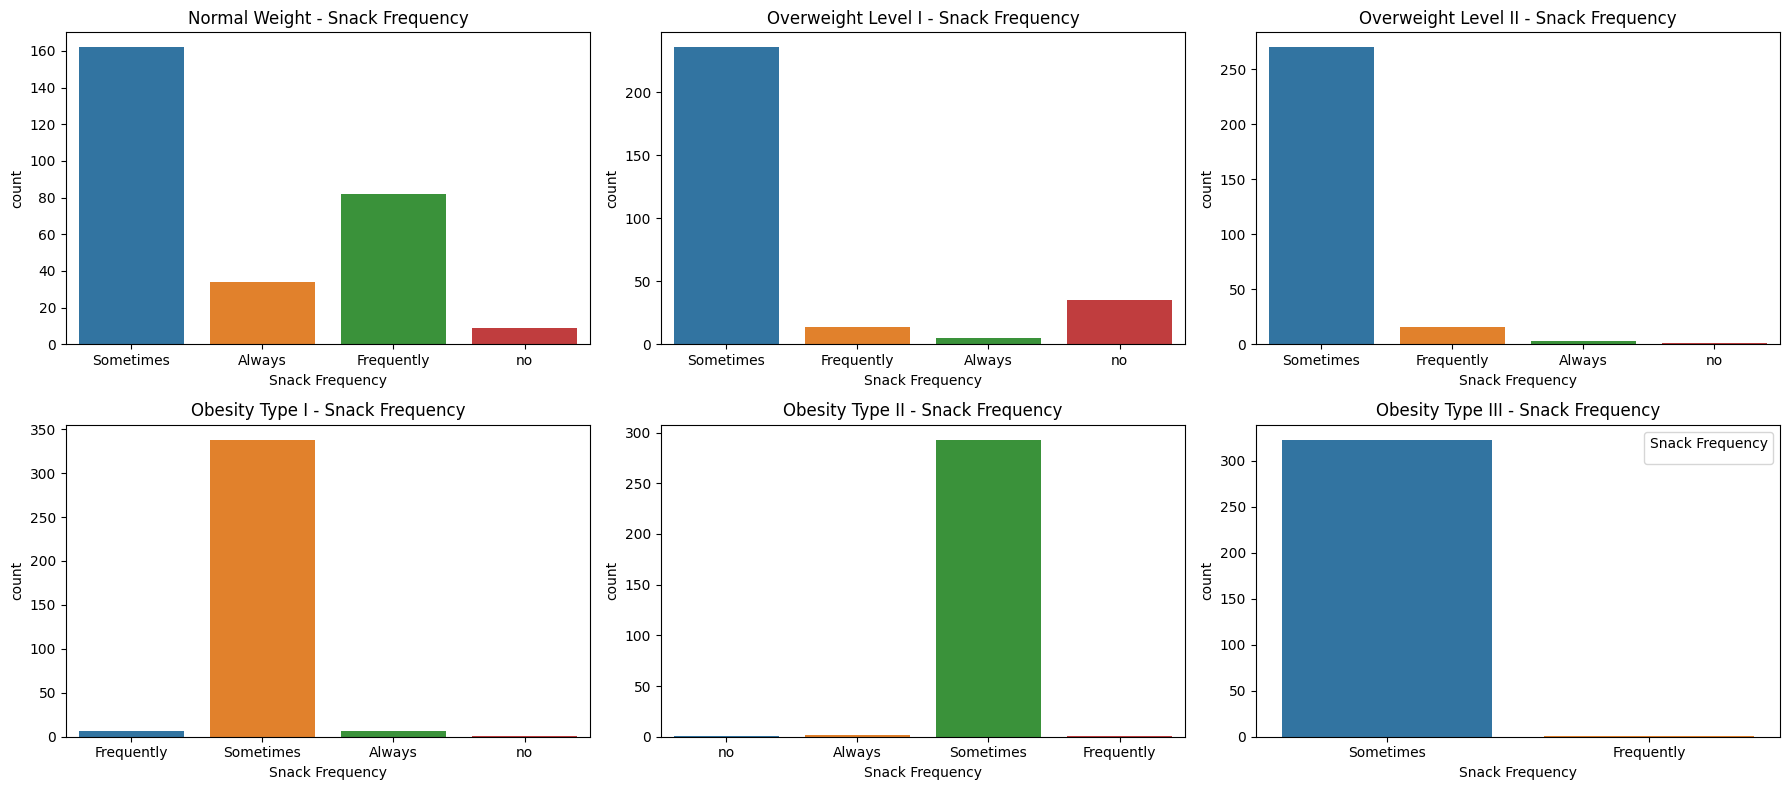

C:\Users\win10\AppData\Local\Temp\ipykernel_13848\4244002769.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=col, loc='upper right')


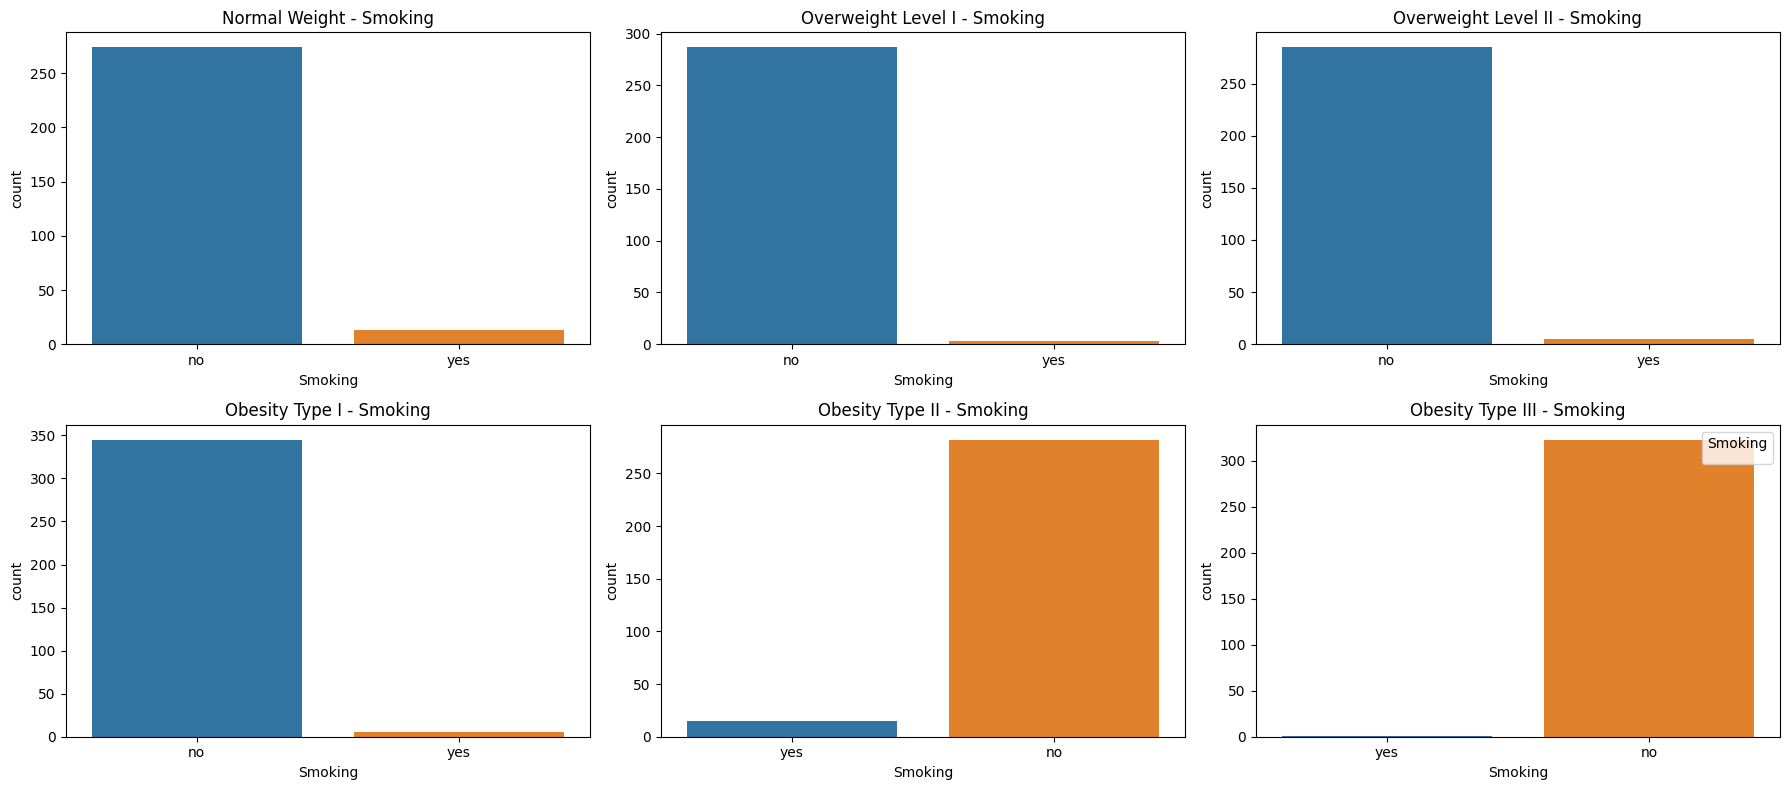

C:\Users\win10\AppData\Local\Temp\ipykernel_13848\4244002769.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=col, loc='upper right')


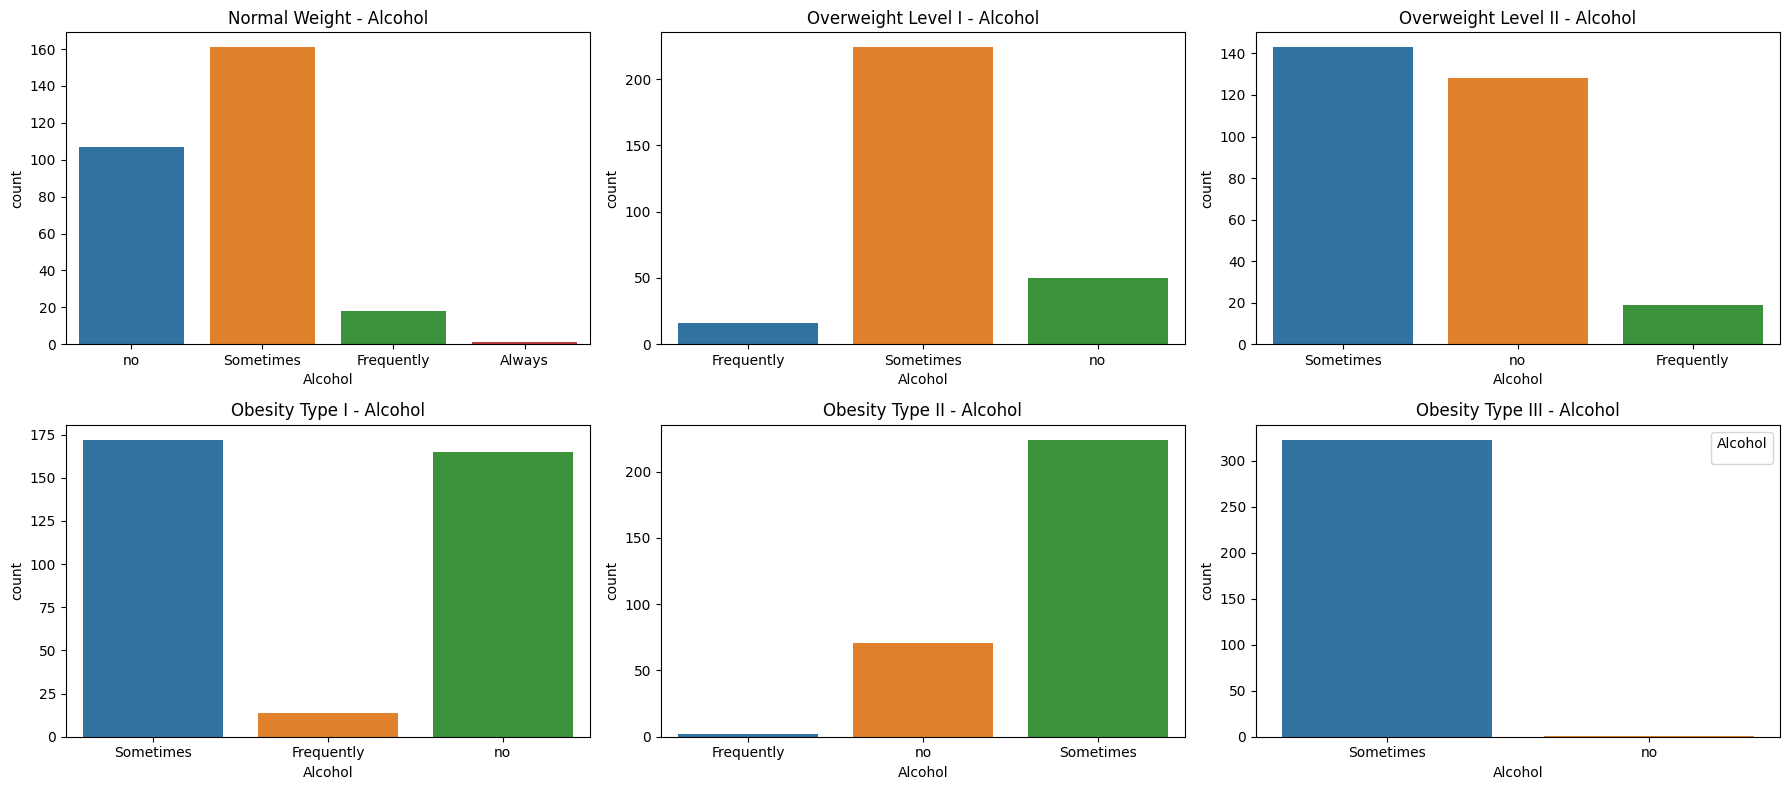

C:\Users\win10\AppData\Local\Temp\ipykernel_13848\4244002769.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=col, loc='upper right')


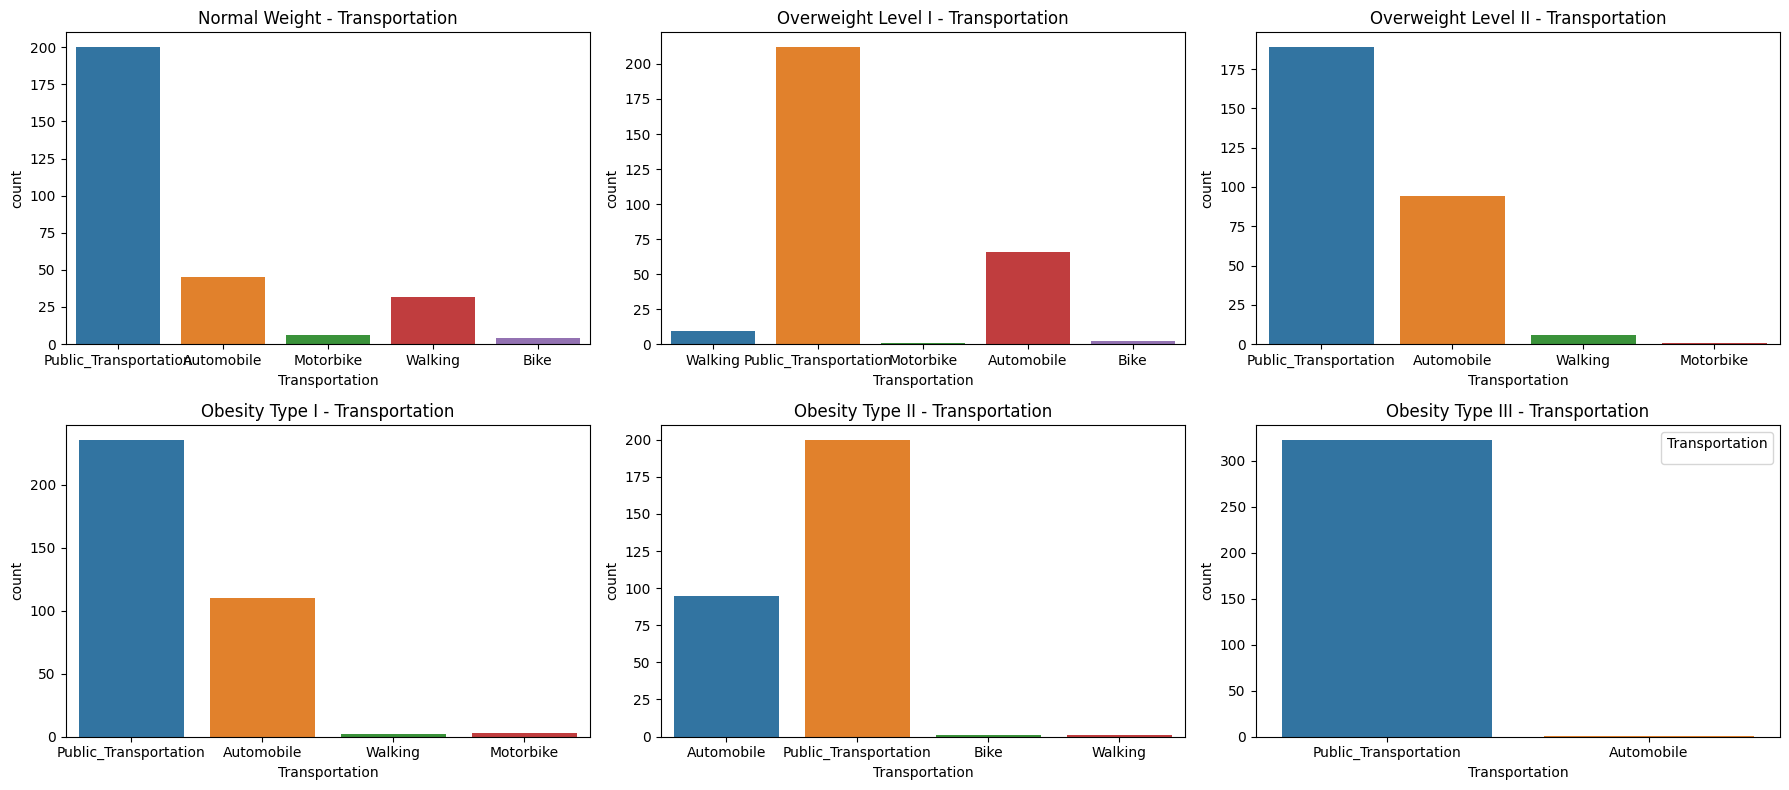

In [326]:
import seaborn as sns
import matplotlib.pyplot as plt

def categorical_distribution(columns):
    for col in columns:
        plt.figure(figsize=(18, 8))

        # Create subplots in a 2x3 grid (2 rows, 3 columns)
        plt.subplot(2, 3, 1)
        sns.countplot(data=nw, x=col, hue=col)
        plt.title(f'Normal Weight - {col}')
        
        plt.subplot(2, 3, 2)
        sns.countplot(data=ow1, x=col, hue=col)
        plt.title(f'Overweight Level I - {col}')
        
        plt.subplot(2, 3, 3)
        sns.countplot(data=ow2, x=col, hue=col)
        plt.title(f'Overweight Level II - {col}')
        
        plt.subplot(2, 3, 4)
        sns.countplot(data=ob1, x=col, hue=col)
        plt.title(f'Obesity Type I - {col}')
        
        plt.subplot(2, 3, 5)
        sns.countplot(data=ob2, x=col, hue=col)
        plt.title(f'Obesity Type II - {col}')
        
        plt.subplot(2, 3, 6)
        sns.countplot(data=ob3, x=col, hue=col)
        plt.title(f'Obesity Type III - {col}')

        # Show legend for each plot
        plt.legend(title=col, loc='upper right')

        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()

categorical_distribution(cat_cols)


Gender - Gender doesn't really shows a significant trend. But Female seem to be more dominant in Obesity Level III. After searching, it is in fact women are more likely to be obese than men, especially after the age of 40. 

Family History With Overweight - People with a family history with overweight definitely has a high chance to be overweight or obesity. But we can see Normal Weight has a lot of Family History with Overweight. This shows that this isn't the main factor of overweight.

High Calorie Meal Freq - A higher frequency in eating high calorie meal definitely cause more people to be overweight or obese. This is because it may causes increases the likelihood of consuming more calories than the body needs, promoting fat storage, hormonal imbalances, and changes in metabolism that collectively contribute to weight gain and obesity.

Snack Frequency - an increased in snack frequency, particularly with unhealthy food choices, can lead to excessive calorie intake, disrupted hunger cues, insulin imbalances, and a sedentary lifestyle—all of which contribute to weight gain and the development of obesity.

Smoking - The data on smoking is predominantly showing "no smoking" for all categories of overweight or obesity, it suggests that the dataset is imbalanced, meaning that the "no smoking" group is overrepresented compared to the "smoking" group.

Alcohol - the data distribution for alcohol consumption is skewed towards "sometimes," followed by "no" and then "frequently," this suggests that the majority of the population in the dataset reports moderate or occasional alcohol consumption, with fewer individuals reporting no alcohol consumption at all and even fewer reporting frequent consumption. 

Transportation - The data on transportation is dominantly showing "Public_Transportation" for all categories, it shows that he dataset is imbalanced, meaning the "Public_Transporation" groups is overrepresented compared to the other groups.

In [327]:
for i in num_cols:
    print(i, shapiro(df[i]), '\n')

Height ShapiroResult(statistic=0.9934381834917068, pvalue=2.726468586202164e-07) 

Weight ShapiroResult(statistic=0.9793821933148907, pvalue=1.2564944438647584e-15) 

Veggies in Meals freq ShapiroResult(statistic=0.8387247264413908, pvalue=1.1194829632555635e-39) 

Daily Main Meals ShapiroResult(statistic=0.6992031578485833, pvalue=2.7833426693014e-49) 

Daily Water Consumption ShapiroResult(statistic=0.9332552796632436, pvalue=6.294765349481614e-28) 

Weekly Physical Activity ShapiroResult(statistic=0.9088823684623589, pvalue=7.939355167441148e-32) 



From the shapiro test above, the pvalue for all the variable is < 0.05 which means the data is not normally distributed, therefore we use robust scaling 

# <span style="color:red">Encoding</span>

In [328]:
label_encoder = LabelEncoder()
label_cols = ['Gender', 'Family History With Overweight', 'High Calorie Meal Freq',
              'Smoking']
for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [329]:
ord_enc = OrdinalEncoder(categories=[['Normal_Weight','Overweight_Level_I', 
                                      'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']])
df['Obesity level'] = ord_enc.fit_transform(df[['Obesity level']])

In [330]:
ohe_enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
oh_encoded = ohe_enc.fit_transform(df[['Transportation', 'Alcohol', 'Snack Frequency']])
one_hot_df = pd.DataFrame(oh_encoded, columns=ohe_enc.get_feature_names_out(['Transportation', 'Alcohol', 'Snack Frequency']))
one_hot_df.index = df.index
df = pd.concat([df.drop(columns=['Transportation', 'Alcohol', 'Snack Frequency']), one_hot_df.astype('int')], axis=1)

In [331]:
X = df.drop(columns=['Obesity level'])  # Exclude target and irrelevant column
y = df['Obesity level']

# <span style="color:red">SMOTE</span> 

SMOTE is used to balanced the data

In [332]:
smote = SMOTE(random_state= 42)
x_balanced, y_balanced = smote.fit_resample(X,y)

print(pd.Series(y_balanced).value_counts())

Obesity level
0.0    351
1.0    351
2.0    351
3.0    351
4.0    351
5.0    351
Name: count, dtype: int64


# <span style="color:red">Train - Test Split</span>

In [333]:
X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

In [334]:
label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([y_train, y_test], axis=0))

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# <span style="color:red">Scaling</span>

In [335]:
rob = RobustScaler()

X_train[num_cols] = rob.fit_transform(X_train[num_cols])
X_test[num_cols] = rob.transform(X_test[num_cols])

# <span style="color:red">Before Grid Search</span>

### Random Forest - Before Grid Search

In [346]:
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

### XG Boost - Before Grid Search

In [347]:
xg_model = xgb.XGBClassifier(random_state=123)
xg_model.fit(X_train, y_train)
xg_pred = xg_model.predict(X_test)

### Analysis

In [348]:
print("\n\nRANDOM FOREST")
print("Classification Report:\n", classification_report(y_test, rf_pred, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))

print("\n\nXG BOOST")
print("Classification Report:\n", classification_report(y_test, xg_pred, zero_division=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, xg_pred))



RANDOM FOREST
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.94      0.91        79
         1.0       0.93      0.90      0.92        72
         2.0       0.94      0.93      0.93        67
         3.0       0.98      0.95      0.97        63
         4.0       1.00      1.00      1.00        74
         5.0       1.00      1.00      1.00        67

    accuracy                           0.95       422
   macro avg       0.96      0.95      0.95       422
weighted avg       0.95      0.95      0.95       422

Confusion Matrix:
 [[74  5  0  0  0  0]
 [ 5 65  2  0  0  0]
 [ 4  0 62  1  0  0]
 [ 1  0  2 60  0  0]
 [ 0  0  0  0 74  0]
 [ 0  0  0  0  0 67]]


XG BOOST
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97        79
         1.0       0.93      0.96      0.95        72
         2.0       0.96      0.96      0.96        67
         3.0       

XGBoost has a higher prediction than Random Forest, but let see each condition with GridSearch

# <span style="color:red">GridSearch</span>

### Random Forest - GridSearch

In [336]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1,2,4],
    'max_features' : [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf_model = RandomForestClassifier(random_state=42)
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

best_rf = rf_grid_search.best_estimator_

# Predictions
rf_predictions = best_rf.predict(X_test)

# Evaluation
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions, average='weighted')
rf_classification_report = classification_report(y_test, rf_predictions)

# Results
print("Random Forest - Best Params:", rf_grid_search.best_params_)
print("Random Forest - Accuracy:", rf_accuracy, "F1-Score:", rf_f1)
print("Random Forest - Classification Report :\n", rf_classification_report)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


Random Forest - Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest - Accuracy: 0.9691943127962085 F1-Score: 0.9692162457055495
Random Forest - Classification Report :
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96        79
         1.0       0.91      0.94      0.93        72
         2.0       0.97      0.93      0.95        67
         3.0       0.97      1.00      0.98        63
         4.0       1.00      1.00      1.00        74
         5.0       1.00      1.00      1.00        67

    accuracy                           0.97       422
   macro avg       0.97      0.97      0.97       422
weighted avg       0.97      0.97      0.97       422



In [367]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],           
    'max_depth': [3, 5, 7, 10, 15],                 
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],   
    'subsample': [0.6, 0.8, 1.0],                   
    'colsample_bytree': [0.6, 0.8, 1.0],           
    'colsample_bylevel': [0.6, 0.8, 1.0],           
    'min_child_weight': [1, 3, 5, 7],               
    'gamma': [0, 0.1, 0.5, 1],                      
    'reg_alpha': [0, 0.01, 0.1, 1],                
    'reg_lambda': [1, 5, 10],                       
    'scale_pos_weight': [1, 5, 10],                
    'objective': ['binary:logistic', 'multi:softprob'],  
}


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_gs = GridSearchCV(estimator = xg_model,param_grid = xgb_param_grid, cv=3, n_jobs=-1, scoring = 'accuracy')
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []

for train_index, val_index in strat_kfold.split(X_train, y_train):
    
    X_kfold_train = X_train.iloc[train_index]
    X_kfold_val = X_train.iloc[val_index]
    y_kfold_train = y_train.iloc[train_index]
    y_kfold_val = y_train.iloc[val_index]

    y_kfold_train_encoded = label_encoder.transform(y_kfold_train)
    y_kfold_val_encoded = label_encoder.transform(y_kfold_val)

    xgb_model.fit(X_kfold_train, y_kfold_train_encoded) 
    y_val_pred = xgb_model.predict(X_kfold_val)

    fold_accuracy = accuracy_score(y_kfold_val_encoded, y_val_pred)  
    fold_accuracies.append(fold_accuracy)

print(f"Accuracy per fold {fold_accuracies}")
print(f"Average Stratified K-Fold Accuracy : {sum(fold_accuracies) / len(fold_accuracies):.2f}")

y_train_encoded = label_encoder.transform(y_train)
xgb_model.fit(X_train, y_train_encoded)

y_test_encoded = label_encoder.transform(y_test)
test_accuracy = accuracy_score(y_test_encoded, xgb_model.predict(X_test))
print(f"Test Set Accuracy: {test_accuracy :.2f}")

y_pred = xgb_model.predict(X_test)
xg_accuracy = accuracy_score(y_test, y_pred)
xg_f1 = f1_score(y_test, y_pred, average='weighted')
xg_classification_report = classification_report(y_test, y_pred)
report = classification_report(y_test_encoded, y_pred) 

print("XG Boost - Accuracy:", xg_accuracy, "F1-Score:", xg_f1)
print("XG Boost - Classification Report :\n", report)

c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:42:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Accuracy per fold [0.9762611275964391, 0.9792284866468842, 0.9762611275964391, 0.973293768545994, 0.9732142857142857]
Average Stratified K-Fold Accuracy : 0.98


c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy: 0.98
XG Boost - Accuracy: 0.976303317535545 F1-Score: 0.9763278304067482
XG Boost - Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.95      0.97        79
           1       0.93      0.96      0.95        72
           2       0.96      0.96      0.96        67
           3       0.98      1.00      0.99        63
           4       1.00      1.00      1.00        74
           5       1.00      1.00      1.00        67

    accuracy                           0.98       422
   macro avg       0.98      0.98      0.98       422
weighted avg       0.98      0.98      0.98       422



Random Forest has a slight increase in accuracy

There is an error when I use GridSearchCV on XGBoost (I cannot run it after many tries), therefore I use the methods K-folds. I know that K-folds isn't actually finetuning, but it will help to maximize the use of limited data by training and testing on every data point. It will also reduce overfitting and provide better generalization estimates.
It provides a fairer and more consistent way to evaluate models compared to a single train-test split.

### Analysis

Both Model shows a really good results across various metrics, from recall, F1 score, precision, and most importantly accuracy. But XGBoost has a slightly better result with a difference of 0.01 from Random Forest. The accuracy is almost 100% which means really good in predicting levels of obesity which is really important to not get it wrong.

# <span style="color:red">Conclusions</span>

Best models for this dataset is XGBoost by a slight difference of 0.01. The results after fine tuning shows a slight increase. We should get the parameters from the default : 


In [369]:
print(xgb_model.get_params())

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}


As we can see, there are so many factors that may affect the result we get, and we would have to spend a lot of time to find the optimal parameters. So using the default parameters may be the best case. 

In [370]:
feature_names = X.columns.tolist()
feature_importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print("Top 10 Important Features:\n", feature_importance_df.head(10))

Top 10 Important Features:
                        Feature  Importance
0                       Gender    0.223040
5        Veggies in Meals freq    0.142166
2                       Weight    0.131567
4       High Calorie Meal Freq    0.073599
17           Alcohol_Sometimes    0.070843
18                  Alcohol_no    0.063748
1                       Height    0.057686
21   Snack Frequency_Sometimes    0.046382
20  Snack Frequency_Frequently    0.038792
8      Daily Water Consumption    0.025131


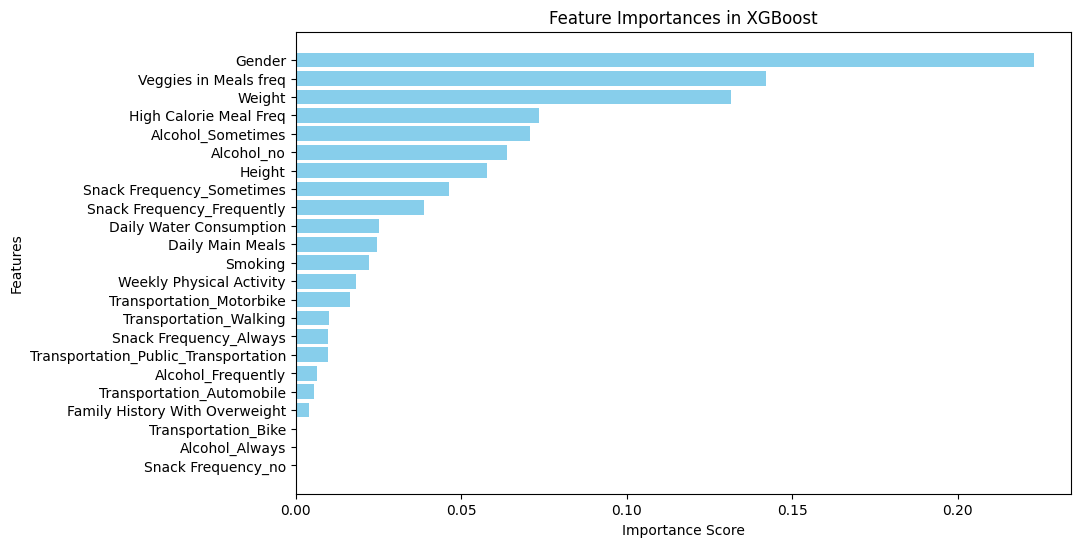

In [371]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances in XGBoost')
plt.gca().invert_yaxis()  
plt.show()


1. Gender being the most important feature aligns with known health trends. In many studies, women tend to have a higher risk of obesity, especially as they age, due to hormonal changes and metabolic factors. 
2. Veggies in Meals freq shows the second most importance score, this shows that the less veggies we consume the more likely to be overweight
3. The fact that weight isn't the most important factor in determining obesity is intriguing, considering its direct relationship to body mass. It might be that my model does not distinguishing between relative measures like weight and BMI, or there could be interaction effects with other features.
4. While other factors might follow the expected trends based on my exploratory data analysis (EDA), their impact may not be as strong as some of the more obvious features (e.g., gender, veggies). This suggests that some features may have non-linear relationships or could be noisy.

# <span style="color:red">Advice and Future Works</span>

While achieving 0.98 accuracy with XGBoost is promising, further improvements in data quality, feature engineering, and model interpretability are needed to ensure real-world applicability in healthcare.
1. Ensure balanced datasets to prevent biases, especially in gender representation. Adding more context (age, health status) could improve predictions.
2. Explore transformations or interactions between features to capture more complex relationships.
Future Work:
3. Integrate real-time health data and external metrics like blood pressure.
4. Experiment with ensemble methods or deep learning models to uncover hidden patterns.
4. Conduct studies over time to track lifestyle changes and their long-term effects on obesity.

